# Automatic Detection of Hyperparameters for k-NN Models

Alexis Rosenfeld & François Delafontaine

## 1. Objective

This project explores the relationship between dataset characteristics and hyperparameter selection, particularly the best `k` for k-Nearest Neighbors (k-NN). 

For a given dataset `A` = {y, x1, x2, ..., xn} we derive a set of features `mx` = {mx1, mx2, ..., mxn} that describe A. Those features should predict the best `k` (number of neighbors) hyperparameter for A:

> $\pi$(mx) = k.

We limit ourselves to the k-NN's one hyperparameter and also limit the type of dataset `A` in size, complexity, distribution, etc., notably by only allowing quantitative features. The dataset used to train our model will be called `D` = {best_k, mx}.

## 1. Data & features

We recognize, for this project, three types of data:
1. Real: datasets found online
2. Simulated: datasets where `k` is generated first, then `mx` derived through formulas.
3. Tested: datasets where `mx` is generated first and `k` obtained through k-NN iteration.

This presentation will rely solely on (3), as the data generated can also be used to train, test and evaluate our model. We plan to use (2) to test model's behavior and eventually (1) as a more general evaluation.

As for the features, we followed the following leads:
- A rule of thumb where k = sqrt(nb_of_datapoints)/2.
- The level of noise, which here will mean how much the datapoints overlap.
- Potentially the type of distribution (linear, quadratic, etc.).

We therefore selected the following `mx` features:
* a) n_rows: the number of `A`'s datapoints
* b) n_classes: with `A` having a categorical dependent variable, this is its number of values
* c) n_features: the number of `A`'s features
* d) n_nonrand: the number of `A`'s features that are non-random (defined by correlation, weighted by (c))
* e) distr_type: the type of distribution the non-random features follow (linear, quadratic, partial)
* f) distr_noise: how likely the values are to overlap (how wide the interval for data generation)
* g) mean_var: the average sum of variance of `A`'s features, weighted by (a\*c)
* h) mean_skew: the average sum of skew of `A`'s features, weighted by (a\*c)
* i) mean_kurtosis: the average sum of kurtosis of `A`'s features, weighted by (a\*c)

And generated a ~4,000 datapoints `D` dataset. The code below illustrates what an `A` dataset looks like, as well as the relations between `best_k` and each of our 9 features.

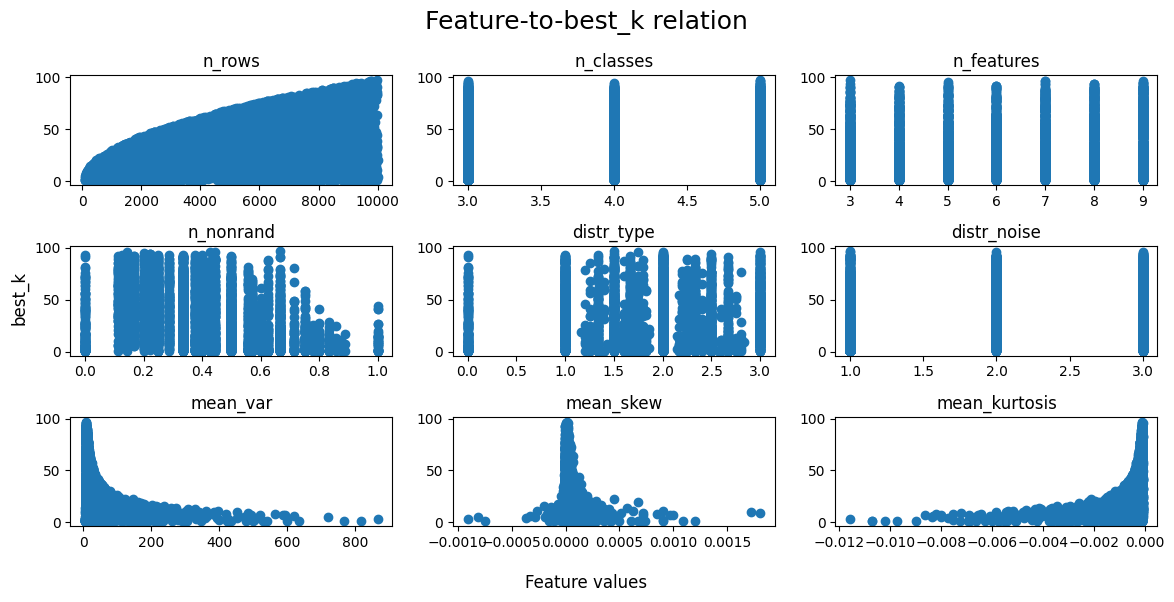

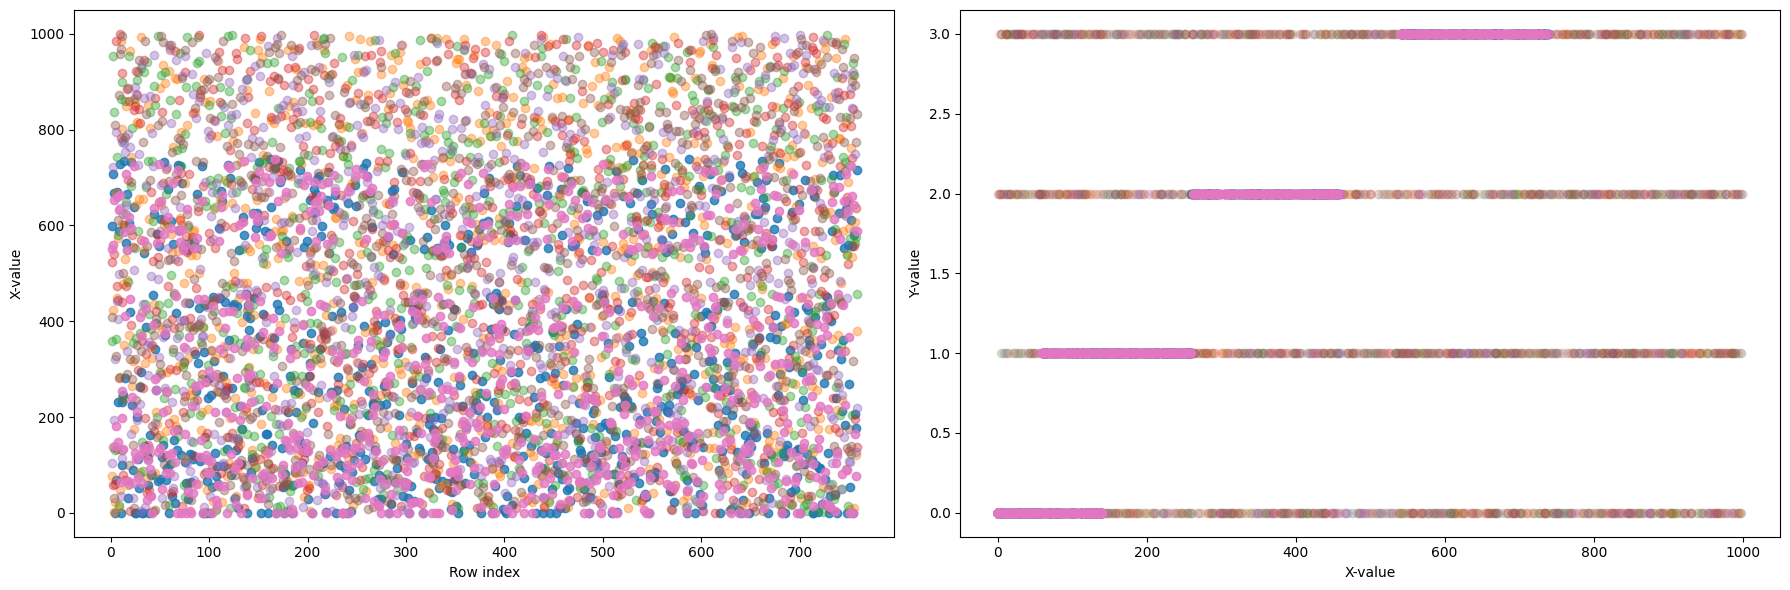

n_rows: 758
n_classes: 4
n_features: 7
n_nonrand: 0.2857142857142857
distr_type: 1
distr_noise: 100.64047270351854
mean_var: 0.00013659560863408713
mean_skew: -0.0016158684747468552


In [1]:
from kg_test import KG_test
kg_test = KG_test() # testing class
# dat = kg_test.sim(2000, "kg_test.xlsx", verbose=True)
dat = kg_test.load("kg_test.xlsx")       # load an existing dataset

kg_test.show_features(dat)               # best_k-to-feature scatterplots
kg_test.params({'lim_row':[500,1000], 
                'distr_type':2, 
                'distr_noise':1})        # control generation (limited)
x, y, d_vi = kg_test.generate(view=True) # generate&plot a dataset
vf = [f"{kg_test.head[i+1]}: {v}" for i, v 
      in enumerate(kg_test.get_features(x, y, d_vi))] # generation values
for txt in vf:
    print(txt)

## 2. Pipeline

### 2.1. Pre-process

Once the dataset has been obtained, we preprocess it in three steps:
1. One-hot encoding: We split categorical columns into multiple binary ones
2. Scaling: Values vary from e4 to e-4 or more. We scale them around e0 (and restore categoricals to 0/1 values)
3. Feature selection: We remove features that don't get at least a 0.2 correlation (categorical columns of a given feature are all kept)

A manual feature selection could also be done, if only by iterating models, so our pipeline allows for skipping step (3).

In [2]:
from kg_model import KG_model

kg = KG_model()
x, y = kg.preprocess(dat[:,1:], dat[:,0])

OneHotEncoded:
	 ['best_k', 'n_rows', 'n_classes', 'n_features', 'n_nonrand', 'distr_type', 'distr_noise_1', 'distr_noise_2', 'distr_noise_3', 'mean_var', 'mean_skew', 'mean_kurtosis']
Selected:                              
	 ['best_k', 'n_rows', 'n_nonrand', 'distr_noise_1', 'distr_noise_2', 'distr_noise_3', 'mean_var', 'mean_kurtosis']


### 2.2. Model

Since the `k` is a quantitative value, we chose to train a Linear Regression model. 

We test that model in two ways:
1. A 5-fold cross-validation on a training subset
2. An MSE/R2 score on the entire set

This means we split our dataset into a training and an evaluation dataset, use the training set for the cross-validation then train our model on that entire training set and get our MSE and R2 scores using the evaluation set. 

It is technically possible to retrieve more information on the linear regression model (coefficient, std, t-value, p-value). This is only partially implemented. [Note: As in I sometimes can't inverse the matrix, othertimes get divisions by zero and basically it's not worth the effort.]

In [4]:
kg.test(x, y, preprocess=False); print("")

Model Performance:
Cross-validation mean: 0.37 , std: 0.02
Mean Square Error: 388.08
R² Score: 0.38



## 3. Results

So far our model's performance is quite bad, with an accuracy of ~0.38. 

This might be due to unreliable features, something that remains to be tested through further simulations; or it might be that a linear regression is not adapted for this task.